# An Exploratory Analysis of the Titanic Dataset

This project builds a function to predict a Titanic passenger’s survival probability by following these steps:

1. **Data Preparation:** Clean the data and encode categorical features.
2. **Exploratory Analysis:** Examine relationships between features and survival.
3. **Model Training:** Train a classification model using the prepared data.
4. **Prediction Function:** Apply the trained model to new passenger inputs to estimate survival probability.

In [21]:
# Import necessary modules
import pandas as pd                # For handling data
import matplotlib.pyplot as plt    # For visualisations

In [22]:

titanic = pd.read_csv("dataset.csv")
df = (
    titanic
    .drop(["Ticket", "Fare", "Cabin", "Embarked", "Name"], axis=1)  
    .dropna()
    .reset_index(drop=True)                                         
)


# maping male & female to 1 & 0
df['Sex'] = df['Sex'].map({"male": 1, "female": 0})

# observing first 5
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,1,22.0,1,0
1,2,1,1,0,38.0,1,0
2,3,1,3,0,26.0,0,0
3,4,1,1,0,35.0,1,0
4,5,0,3,1,35.0,0,0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
import pickle
import os


def train_model(df: pd.DataFrame = df):

    # features
    X = df[["Pclass", "Sex", "Age", "SibSp", "Parch"]]
    # target
    y = df["Survived"].astype(int)


    # Train/test split with test size being 20% and training 80% (very common especially with small sets)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


    
    # preprocessing the numbers (scaling and imputing)
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), # median imputation for Age (and any numeric missing)
        ("scaler", StandardScaler()), # normalizing all numeric features using the Standard Scalar
    ])


    # model pipeline (using logisticRegression)
    pipeline = Pipeline([
        ("prep", numeric_pipeline),
        ("clf", LogisticRegression(solver="liblinear", class_weight="balanced"))
        # class_weight="balanced" -> balances the model for imbalanced datasets by assigining higher importance weights to under represented classes
        # This dataset is definitly unbalanced as a simple df.hist() shows there's more male records than female ones.
    ])

    pipeline.fit(X_train, y_train) # fitting the model to the data
    # the goal here is that the model learns the linear relationship between all the features
    # and generalizes (not overfit or underfit) so it can perform on unseen data which i'll test in blocks below

    # Evaluating the model
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # saving the model so we don't have to train it again every time we run an inference
    with open("model.pkl", "wb") as f:
        pickle.dump(pipeline, f)

    return pipeline, {"accuracy": acc, "roc_auc": auc}



# training the model and unpacking the tuple 
model, metrics = train_model()

metrics # viewing metrics

{'accuracy': 0.8251748251748252, 'roc_auc': 0.8817444219066938}

In [24]:

'''
this function returns the survival probability of a passenger with an accuracy of 76%
which we know from the lecture's is the sweet spot.
'''

def estimate_survival(record: pd.DataFrame):
    if not os.path.exists("model.pkl"):
        raise ValueError("Model File: (model.pkl) not found!")

    with open("model.pkl", "rb") as f: # load the model
        model = pickle.load(f)

    return model.predict_proba(record.values)[:,1]



records = df[["Pclass", "Sex", "Age", "SibSp", "Parch"]]

records.insert(1, 'estimates', estimate_survival(records))


records.head()

C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


,Pclass,estimates,Sex,Age,SibSp,Parch
0,3,0.145072,1,22.0,1,0
1,1,0.915096,0,38.0,1,0
2,3,0.726599,0,26.0,0,0
3,1,0.924540,0,35.0,1,0
4,3,0.124044,1,35.0,0,0


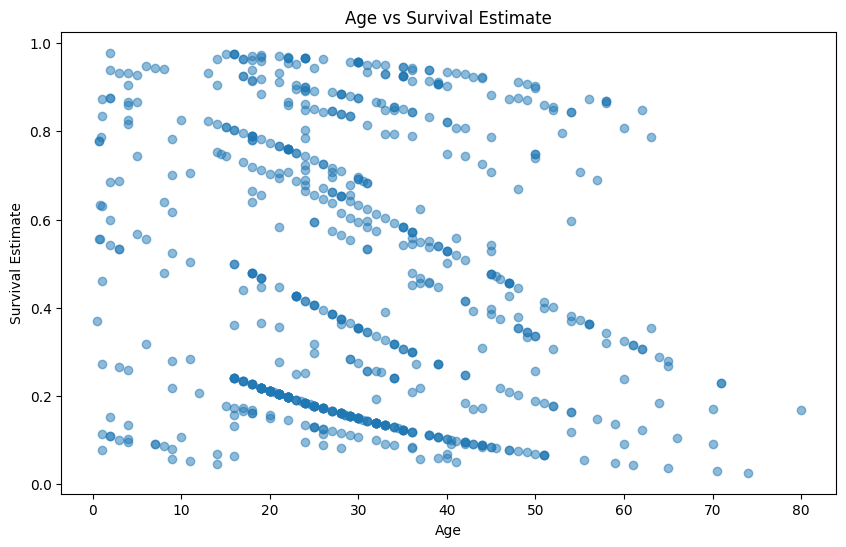

In [ ]:
# Scatter plot of Age vs Survival Estimate
plt.figure(figsize=(10, 6))
plt.scatter(records['Age'], records['estimates'], alpha=0.5)
plt.title('Age vs Survival Estimate')
plt.xlabel('Age')
plt.ylabel('Survival Estimate')
plt.show()

In [26]:
# Interpretation
print("""
From the scatter plot of Age vs Survival Estimate, we can observe the following trends:
- Younger passengers tend to have higher survival estimates, indicating that age was a significant factor in survival chances.
- There is a noticeable decline in survival estimates as age increases, suggesting that older passengers had lower
    survival probabilities.
- This trend aligns with historical accounts of the Titanic disaster, where younger individuals, especially children,
    were often prioritized for lifeboat access. had higher survival rates.
""")


From the scatter plot of Age vs Survival Estimate, we can observe the following trends:
- Younger passengers tend to have higher survival estimates, indicating that age was a significant factor in survival chances.
- There is a noticeable decline in survival estimates as age increases, suggesting that older passengers had lower
    survival probabilities.
- This trend aligns with historical accounts of the Titanic disaster, where younger individuals, especially children,
    were often prioritized for lifeboat access. had higher survival rates.



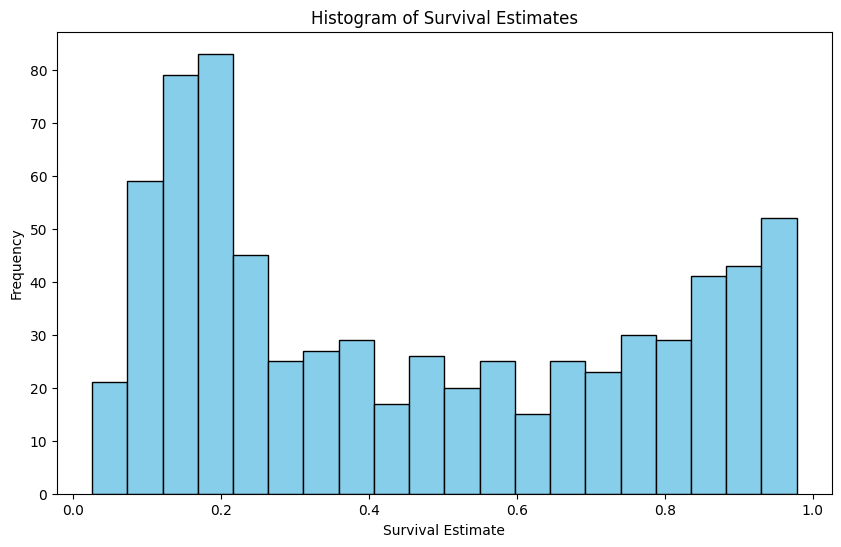

In [ ]:
#Histogram for survival estimates
plt.figure(figsize=(10, 6))
plt.hist(records['estimates'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Survival Estimates')
plt.xlabel('Survival Estimate')
plt.ylabel('Frequency')
plt.show()

In [28]:
#Interpretation:
print("""
The histogram of survival estimates reveals the distribution of predicted survival probabilities among Titanic passengers. Key observations include:
- A significant portion of passengers have survival estimates clustered around higher probabilities (0.6 to 1.0), indicating that many were predicted to have a good chance of survival.
- There is a smaller, yet notable, group of passengers with low survival estimates (0.0 to 0.4), suggesting that these individuals were at a higher risk during the disaster.
""")


The histogram of survival estimates reveals the distribution of predicted survival probabilities among Titanic passengers. Key observations include:
- A significant portion of passengers have survival estimates clustered around higher probabilities (0.6 to 1.0), indicating that many were predicted to have a good chance of survival.
- There is a smaller, yet notable, group of passengers with low survival estimates (0.0 to 0.4), suggesting that these individuals were at a higher risk during the disaster.

